# Analytical Thermodynamics and Non-equilibrium Metrics 

This notebook accompanies the manuscript (Berjaga-Buisan et al., Thermodynamics of consciousness: A non-invasive perturbational framework, 2025) and provides a fully reproducible workflow for computing and analyzing nonequilibrium (NEQ) metrics grounded in analytical determinants. The metrics implemented here include the **Entropy Production Rate** (Godrèche & Luck, *J. Phys. A: Math. Theor.*, 2019), **Temporal Irreversibility** (Deco et al., *Commun. Biol.*, 2022; Ohga et al., *Phys. Rev. Lett.*, 2022), and **Irreciprocity** (Nartallo-Kaluarachchi et al., *Phys. Rev. E*, 2024).

All metrics are derived from a **Multivariate Ornstein–Uhlenbeck (MOU)** process, which constitutes a linearized simplification of the **Wilson–Cowan model**. Before computing these metrics, it is essential to **fit the Generative Effective Connectivity (GEC) matrix**, as this forms the foundation of the analytical framework. Once the GEC is obtained, the analyses in this notebook can be executed straightforwardly.

For illustrative purposes—and to provide a ready-to-run example—the notebook also generates **synthetic data** that reproduce the structure of the imported data (e.g., dimensions) but not their actual content.

**Please cite Berjaga-Buisan et al., Thermodynamics of consciousness: A non-invasive perturbational framework, 2025 if you use the any part of this code.**


In [1]:
# --- Core environment & imports ---------------------------------------------
import warnings
warnings.filterwarnings("ignore")  # keep the notebook output tidy

# Numerics & data
import numpy as np
import pandas as pd

# Linear algebra & dynamics
from scipy.linalg import solve_continuous_lyapunov, expm

# Stats
from scipy.stats import spearmanr, wilcoxon
from statsmodels.stats.multitest import multipletests

# I/O
from scipy.io import loadmat

# Plotting
import matplotlib.pyplot as plt

In [2]:
# --- Functions for computing Nonequilibrium metrics ---------------------------

def compute_theoretical_covariance(B, sigma):
    """
    Solve the stationary covariance S for the MOU process with drift matrix B

    Parameters
    ----------
    B : (N,N) array_like
    
    sigma : float, default=1.0
        Isotropic diffusion strength (D = sigma I).

    Returns
    -------
    S : (N,N) ndarray
        Stationary covariance matrix.
    """
    eigvals = np.linalg.eigvals(B)
    if np.any(np.real(eigvals) <= 0):
        warnings.warn("Some eigenvalues of B have non-positive real part; "
                      "the process may be unstable under the -B convention.")
    Q = 2.0 * sigma * np.eye(B.shape[0])
    S = solve_continuous_lyapunov(B, Q)
    return S

def asymmetry_tau(B, S, tau):
    """
    Temporal asymmetry/irreversibility at lag tau from the cross-covariance.

    Parameters
    ----------
    B : (N,N) array_like.
    S : (N,N) array_like
        Covariance at lag 0 (stationary S).
    tau : float
        Time lag (≥ 0).
    Returns
    -------
    Asymmetry measure at lag tau.
    """
    n = np.shape(B)[0] # Number of channels
    shifted_tau = np.dot(expm(-B * tau), S) # Shifted correlation for t=0 and t=1
    diag_diff = np.diag(S) - np.diag(shifted_tau) # Substract diagonal of two matrices for normalization
    normalization = 2*np.sqrt(np.outer(diag_diff,diag_diff)) # Normalization term
    xi = (shifted_tau - shifted_tau.T) # Asymmetry (upper diagonal; its symmetric)
    norm_xi = np.linalg.norm(xi,'fro')
    return norm_xi

def compute_entropy_production(B, S, sigma):
    """
    Compute the drift matrix B, solve the Lyapunov equation for the stationary covariance matrix S,
    and compute entropy production (Phi).

    Parameters:
    - Drift matrix B (N X N)

    - S (numpy.ndarray): Stationary covariance matrix.

    Returns:
    - Phi (float): Entropy production.

    """
    I = np.eye(B.shape[0])

    # Compute Q and Entropy Production (Phi)
    Q = np.dot(B, S) - sigma * I
    Phi = -np.trace(np.dot(B, Q)) / sigma

    return Phi

def weighted_irreciprocity(W):
    """
    Compute the weighted irreciprocity of a weighted adjacency matrix.

    Parameters
    ----------
    W : numpy.ndarray
        Square weighted adjacency matrix (N x N)

    Returns
    -------
    r : float
        Weighted reciprocity
    """
    # Ensure input is a NumPy array
    W = np.array(W, dtype=float)

    # Symmetrize using element-wise minimum
    W_symm = np.minimum(W, W.T)

    # Numerator: sum of symmetric weights excluding diagonal
    num = np.sum(W_symm) - np.sum(np.diag(W_symm))

    # Denominator: total weight excluding diagonal
    denom = np.sum(W) - np.sum(np.diag(W))

    # Avoid division by zero
    r = num / denom if denom != 0 else 0.0

    return 1 - r

# --- Functions for Generating Syntethic Generative Effective Connectivities ---------------------------

def generate_asymmetric_gec_set(n_subj, n_nodes, asym_level,maxC=0.2):
    """
    Generate a set of nonnegative, asymmetric GEC matrices with controllable asymmetry.
    It also generates based in the Hurwitz criterion stability imposed.
    Shape: (n_subj, n_nodes, n_nodes)

    Notes
    -----
    - This function draws randomness from a fresh, entropy-seeded Generator each call,
      so results will differ on every run (ignores any global seed).
    - Asymmetry increases with `asym_level`.
    """
    C_list = []
    
    for _ in range(n_subj):
        rng_local = np.random.default_rng()  # entropy-seeded each subject

        # 1) Symmetric nonnegative baseline
        A = rng_local.gamma(shape=2.0, scale=0.15, size=(n_nodes, n_nodes))
        A = 0.5 * (A + A.T)
        np.fill_diagonal(A, 0.0)

        # 2) Directed antisymmetric perturbation
        D = rng_local.normal(loc=0.0, scale=1.0, size=(n_nodes, n_nodes))
        D = D - D.T
        D *= float(asym_level) * 0.10

        # 3) Combine + clip to nonnegative
        C = A + D
        C = np.clip(C, 0.0, None)

        # 4) Set diagonal to sum(|C|, axis=1) - |diag(C)|  (i.e., row-sum of off-diagonals)
        offdiag_sum = np.sum(np.abs(C), axis=1) - np.abs(np.diag(C))
        np.fill_diagonal(C, offdiag_sum)

        # 5) Rescale so max(C) = maxC
        cmax = C.max()
        if cmax > 0:
            C = (C / cmax) * float(maxC)

        C_list.append(C)

    return np.stack(C_list, axis=0)

# --- Functions for Plotting ---------------------------
def scatter_by_condition(ax, x_data, y_data, xlabel, ylabel, colors, labels):
    for x, y, c, lab in zip(x_data, y_data, colors, labels):
        ax.scatter(x, y, color=c, edgecolor='black', alpha=0.8, s=60, label=lab)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticks([0.724,0.725])
    ax.set_ylim(top=0.7251)

In [3]:
# --- Synthetic GEC (Ceff) and FDT data --------------------------------------

# If you compute GEC and FDT values, please change here for the synethtic random generated ones

N_NODES = 32      # number of regions/nodes in the GEC
N_SUBJ  = 8       # subjects per condition

# Higher level → more directed imbalance (more asymmetry)
ASYM_LEVELS = {
    "light": 0.01,
    "mid":   0.0093,
    "deep":  0.0086,
}

# Generate Ceff arrays per condition (each: 8 x N x N)
light_ceff = generate_asymmetric_gec_set(N_SUBJ, N_NODES, ASYM_LEVELS["light"])
mid_ceff   = generate_asymmetric_gec_set(N_SUBJ, N_NODES, ASYM_LEVELS["mid"])
deep_ceff  = generate_asymmetric_gec_set(N_SUBJ, N_NODES, ASYM_LEVELS["deep"])

# --- Random FDT values (higher for light > mid > deep) -----------------------
# Means and tiny SDs chosen to resemble the paper scale ordering
rng_local = np.random.default_rng() 
FDT_light = rng_local.normal(loc=0.72495, scale=2.0e-4, size=N_SUBJ).tolist()
FDT_mid   = rng_local.normal(loc=0.72455, scale=2.0e-4, size=N_SUBJ).tolist()
FDT_deep  = rng_local.normal(loc=0.72425, scale=2.0e-4, size=N_SUBJ).tolist()

In [4]:
# --- Metrics per condition (no changes to logic) -----------------------------
dt = 0.125
sigma = 0.2

asymmetry_light = np.zeros(N_SUBJ)
asymmetry_mid   = np.zeros(N_SUBJ)
asymmetry_deep  = np.zeros(N_SUBJ)

entropy_light = np.zeros(N_SUBJ)
entropy_mid   = np.zeros(N_SUBJ)
entropy_deep  = np.zeros(N_SUBJ)

irreciprocity_light = np.zeros(N_SUBJ)
irreciprocity_mid   = np.zeros(N_SUBJ)
irreciprocity_deep  = np.zeros(N_SUBJ)

for i in range(N_SUBJ):
    # LIGHT
    B = light_ceff[i]
    S = compute_theoretical_covariance(B, sigma)
    asymmetry_light[i]     = asymmetry_tau(B, S, dt)
    entropy_light[i]       = compute_entropy_production(B, S, sigma)
    irreciprocity_light[i] = weighted_irreciprocity(B)

    # MID
    B = mid_ceff[i]
    S = compute_theoretical_covariance(B, sigma)
    asymmetry_mid[i]     = asymmetry_tau(B, S, dt)
    entropy_mid[i]       = compute_entropy_production(B, S, sigma)
    irreciprocity_mid[i] = weighted_irreciprocity(B)

    # DEEP
    B = deep_ceff[i]
    S = compute_theoretical_covariance(B, sigma)
    asymmetry_deep[i]     = asymmetry_tau(B, S, dt)
    entropy_deep[i]       = compute_entropy_production(B, S, sigma)
    irreciprocity_deep[i] = weighted_irreciprocity(B)

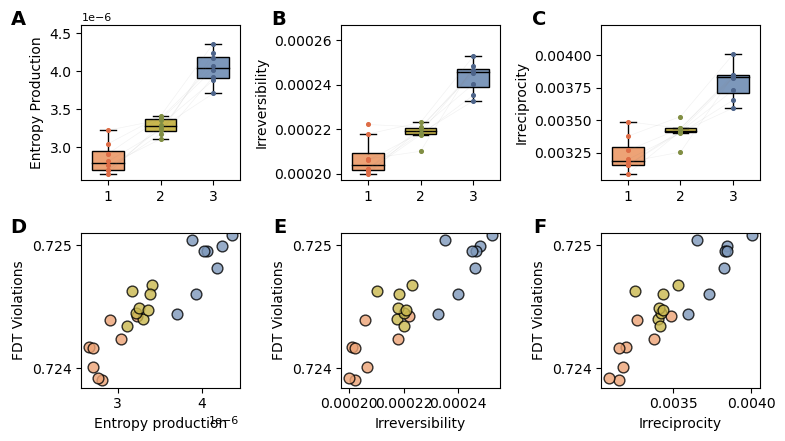

In [5]:
# --- Figure: boxplots (A–C) and scatter panels (D–F) -------------------------

# Data grouped by condition order: Deep (1), Mid (2), Light (3)
entropy_data        = [entropy_deep,        entropy_mid,        entropy_light]
asymmetry_data      = [asymmetry_deep,      asymmetry_mid,      asymmetry_light]
irreciprocity_data  = [irreciprocity_deep,  irreciprocity_mid,  irreciprocity_light]
FDT_data            = [FDT_deep,            FDT_mid,            FDT_light]

# Colors and labels per condition
colors     = ['#eda376', '#cab84e', '#7d98bb']
dot_colors = ['#dd6c46', '#818e43', '#4d648a']
labels     = ['Deep', 'Mid', 'Light']

fig, axes = plt.subplots(2, 3, figsize=(8, 4.5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

metrics_data = [entropy_data, asymmetry_data, irreciprocity_data]
ylabels      = ["Entropy Production", "Irreversibility", "Irreciprocity"]

# Top row: boxplots with paired subject lines and jittered dots
for i, ax in enumerate(axes[0]):
    box = ax.boxplot(
        metrics_data[i],
        patch_artist=True,
        medianprops=dict(color='k', linewidth=1),
        widths=0.6,
        showfliers=False,
        zorder=0,
    )
    for patch, color in zip(box["boxes"], colors):
        patch.set_facecolor(color)

    ax.set_ylabel(ylabels[i])

    # Dynamic y-limits with small headroom
    y_max = max(max(group) for group in metrics_data[i])
    y_bracket = 1.005 * y_max
    ax.set_ylim(top=1.05 * y_bracket)

    # Dots + within-subject pairing lines
    for j, group in enumerate(metrics_data[i]):
        x = np.full(len(group), j + 1.0)
        ax.scatter(x, group, color=dot_colors[j], s=7, zorder=2)

        if j < 2:
            for n in range(len(metrics_data[i][j])):
                ax.plot(
                    [j + 1.0, j + 2.0],
                    [metrics_data[i][j][n], metrics_data[i][j + 1][n]],
                    color='gray', alpha=0.1, linewidth=0.5, zorder=1
                )

# Bottom row: scatter panels (x metric vs FDT) per condition
entropy_x        = [entropy_deep,       entropy_mid,       entropy_light]
asymmetry_x      = [asymmetry_deep,     asymmetry_mid,     asymmetry_light]
irreciprocity_x  = [irreciprocity_deep, irreciprocity_mid, irreciprocity_light]
FDT_y            = [FDT_deep,           FDT_mid,           FDT_light]

scatter_pairs = [
    (entropy_x,       FDT_y, "Entropy production", "FDT Violations"),
    (asymmetry_x,     FDT_y, "Irreversibility",    "FDT Violations"),
    (irreciprocity_x, FDT_y, "Irreciprocity",      "FDT Violations"),
]

for i, ax in enumerate(axes[1]):
    x_data, y_data, xlabel, ylabel = scatter_pairs[i]
    scatter_by_condition(ax, x_data, y_data, xlabel, ylabel, colors, labels)

# Panel letters
letters = ['A', 'B', 'C', 'D', 'E', 'F']
for idx, ax in enumerate(axes.flat):
    ax.text(
        -0.35, 1.1, letters[idx],
        transform=ax.transAxes,
        fontsize=14, fontweight='bold',
        va='top', ha='right'
    )

# Smaller scientific-notation offsets
for ax in fig.axes:
    ax.xaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_fontsize(8)

plt.tight_layout()
#plt.savefig('FIGS4.svg')
plt.show()


In [6]:
# --- Paired comparisons with Holm–Bonferroni correction ----------------------

# Organize data by metric (order: Deep, Mid, Light)
metrics = {
    "entropy":        [entropy_deep,        entropy_mid,        entropy_light],
    "asymmetry":      [asymmetry_deep,      asymmetry_mid,      asymmetry_light],
    "irreciprocity":  [irreciprocity_deep,  irreciprocity_mid,  irreciprocity_light],
}

# Condition pairs to compare (paired Wilcoxon)
pairs = [("deep", "mid"), ("deep", "light"), ("mid", "light")]

results = []

for metric_name, data in metrics.items():
    deep, mid, light = data

    # Wilcoxon tests per pair
    p_vals, comparisons = [], []
    for (c1, c2), (x, y) in zip(pairs, [(deep, mid), (deep, light), (mid, light)]):
        stat, p = wilcoxon(x, y, alternative="two-sided")
        p_vals.append(p)
        comparisons.append(f"{c1} vs {c2}")

    # Holm–Bonferroni within this metric
    reject, p_corr, _, _ = multipletests(p_vals, method="holm")

    # Collect rows
    for comp, p_raw, p_adj, rej in zip(comparisons, p_vals, p_corr, reject):
        results.append({
            "metric":           metric_name,
            "comparison":       comp,
            "p_raw":            p_raw,
            "p_corr_within":    p_adj,
            "reject_within":    rej,
        })

# Results table
results_df = (
    pd.DataFrame(results)
      .sort_values(["metric", "comparison"])
      .reset_index(drop=True)
)

print(results_df)

          metric     comparison     p_raw  p_corr_within  reject_within
0      asymmetry  deep vs light  0.007812       0.023438           True
1      asymmetry    deep vs mid  0.015625       0.023438           True
2      asymmetry   mid vs light  0.007812       0.023438           True
3        entropy  deep vs light  0.007812       0.023438           True
4        entropy    deep vs mid  0.007812       0.023438           True
5        entropy   mid vs light  0.007812       0.023438           True
6  irreciprocity  deep vs light  0.007812       0.023438           True
7  irreciprocity    deep vs mid  0.015625       0.023438           True
8  irreciprocity   mid vs light  0.007812       0.023438           True


In [7]:
# --- Ordinal-condition correlation (Deep=1 < Mid=2 < Light=3) ----------------

# Mapping of condition order
condition_map = {"deep": 1, "mid": 2, "light": 3}

# Data grouped by condition (Deep, Mid, Light)
metrics = {
    "entropy":        [entropy_deep,        entropy_mid,        entropy_light],
    "asymmetry":      [asymmetry_deep,      asymmetry_mid,      asymmetry_light],
    "irreciprocity":  [irreciprocity_deep,  irreciprocity_mid,  irreciprocity_light],
}

corr_results = []

for metric_name, (deep, mid, light) in metrics.items():
    # Concatenate all subjects across conditions
    values = np.concatenate([deep, mid, light])

    # Corresponding ordinal labels
    labels = np.concatenate([
        np.full_like(deep,  fill_value=condition_map["deep"],  dtype=float),
        np.full_like(mid,   fill_value=condition_map["mid"],   dtype=float),
        np.full_like(light, fill_value=condition_map["light"], dtype=float),
    ])

    # Spearman correlation between ordinal condition and metric
    rho, p = spearmanr(labels, values)

    corr_results.append({
        "metric":  metric_name,
        "rho":     rho,
        "p_value": p,
    })

# Results table
corr_df = pd.DataFrame(corr_results)
print(corr_df)

          metric       rho       p_value
0        entropy  0.921512  1.663526e-10
1      asymmetry  0.877280  1.837756e-08
2  irreciprocity  0.877280  1.837756e-08


In [8]:
# --- Correlation of each metric with FDT (all conditions pooled) --------------

# Organize metrics (Deep, Mid, Light)
metrics = {
    "entropy":        [entropy_deep,        entropy_mid,        entropy_light],
    "asymmetry":      [asymmetry_deep,      asymmetry_mid,      asymmetry_light],
    "irreciprocity":  [irreciprocity_deep,  irreciprocity_mid,  irreciprocity_light],
}

# FDT data in the same condition order
FDT_data = [FDT_deep, FDT_mid, FDT_light]

corr_results = []

for metric_name, (deep, mid, light) in metrics.items():
    # Pool subjects across conditions
    metric_values = np.concatenate([deep, mid, light])
    FDT_values    = np.concatenate(FDT_data)

    # Spearman correlation
    rho, p = spearmanr(metric_values, FDT_values)

    corr_results.append({
        "metric":  metric_name,
        "rho":     rho,
        "p_value": p,
    })

# Tabulate results
corr_df = pd.DataFrame(corr_results)
print(corr_df)


          metric       rho       p_value
0        entropy  0.900000  2.156196e-09
1      asymmetry  0.855652  9.864345e-08
2  irreciprocity  0.876522  1.959333e-08
